In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from scipy import  integrate
import pandas as pd
from functools import partial

# The contact model

Ref: Perez, M. et. al. “A multi-scale description of orientation in simple shear flows of confined rod suspensions.” _J. Non-Newtonian Fluid Mech._ **2016**, 233, 61–74.  
  
$$
\left\{\begin{align*}
\mathbf{\dot{p}}&=\mathbf{\dot{p}}^{HD}  &if \ \mathbf{|n\cdot p|}&<2y^*/L &\\ 
\mathbf{\dot{p}}&=\mathbf{\dot{p}}^{HD}  &if \ \mathbf{|n\cdot p|}&=2y^*/L \quad and \quad  \mathbf{\dot{p}}^{HD}\cdot\ \mathbf{n} \leq 0 &\\ 
\mathbf{\dot{p}}&=\mathbf{\dot{p}}^{HD}+\mathbf{\dot{p}}^{C}  &if \ \mathbf{|n\cdot p|}&=2y^*/L \quad and \quad  \mathbf{\dot{p}}^{HD}\cdot\ \mathbf{n} > 0 &
\end{align*}\right.  \\
\  \\
\  \\
\begin{aligned}
where \quad  

\mathbf{\dot{p}}^{HD}&=\mathbf{W\cdot p}+\xi (\mathbf{D\cdot p-D:ppp}) &\\
\mathbf{D}&=\frac{1}{2}(\mathbf{\nabla v-\nabla v}^T) &\\
\mathbf{W}&=\frac{1}{2}(\mathbf{\nabla v+\nabla v}^T) &\\
and \quad 
\mathbf{\dot{p}}^{C}&=-\frac{\mathbf{\dot{p}}^{HD} \cdot \mathbf{n}}{1-(\mathbf{|n\cdot p|})^2} (\mathbf{n-|n\cdot p|p}) &
\end{aligned}
$$

# Function Definition

In [2]:
def contact_model(t,p,rho,y_L_ratio=0.5):
    '''
    y_L_ratio is the confinement factor
    rho: the aspect ratio of the fiber
    p: the orientation of the fiber
    ref: Perez, M. et. al. Journal of Non-Newtonian Fluid Mechanics 233, 61-74 (2016).
    '''
    shear_rate=1
    # the normal direction of the wall
    n=np.array([0,1,0])
    #L: the velocity gradient tensor
    L=np.zeros((3,3),dtype=np.float64)
    L[0,1]=shear_rate
    #D the deformation tensor, W the rotation tensor
    I=np.eye(3)
    D=0.5*(L.T+L)
    W=0.5*(L-L.T)
    dp_HD=np.dot(W,p)+(rho**2-1)/(rho**2+1)*(np.dot(D,p)-np.dot(np.dot(D,p),p)*p)
    dp_C=-np.dot(dp_HD,n)/(1-np.dot(n,p)**2)*(n-np.abs(np.dot(n,p))*p)
    if np.abs(np.dot(n,p))<2*y_L_ratio:
        dp=dp_HD
    elif np.dot(dp_HD,n)<0:
        dp=dp_HD
    else:
        dp=dp_HD+dp_C
    return dp

# Change $\theta$ to calculate fiber tumbling trajectory

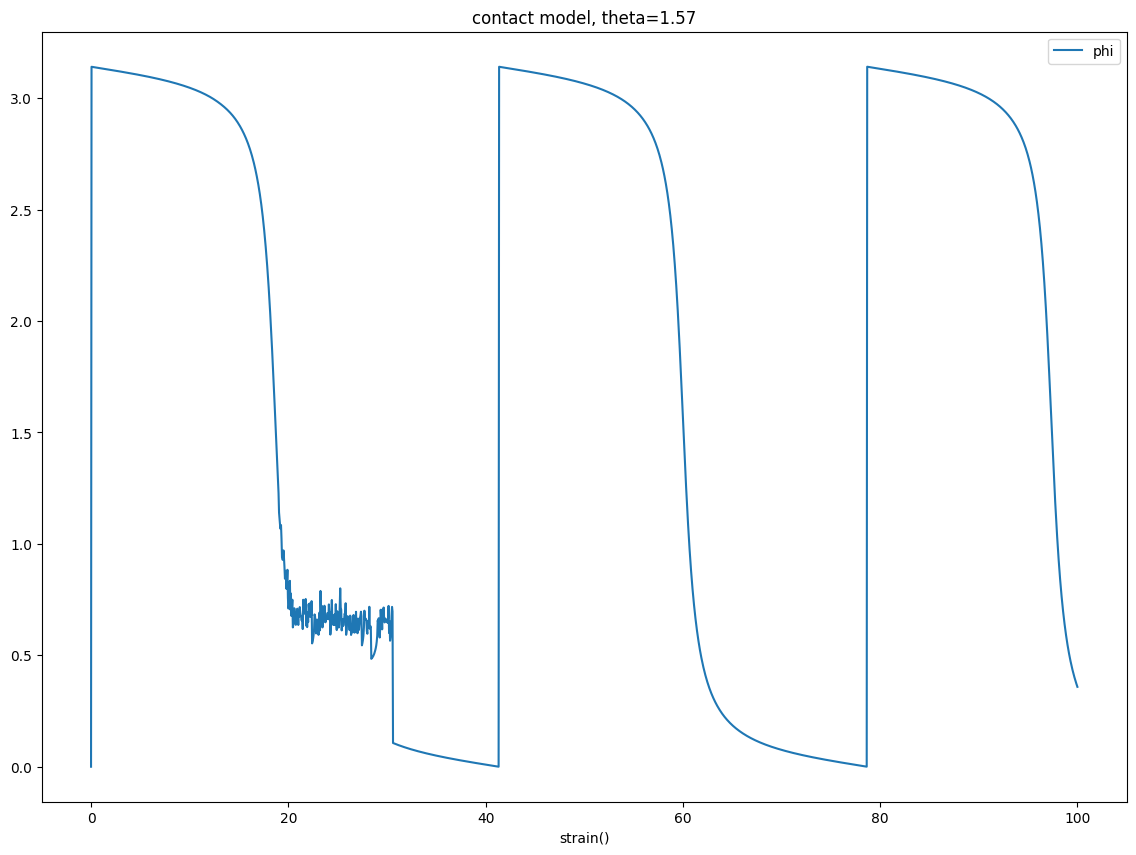

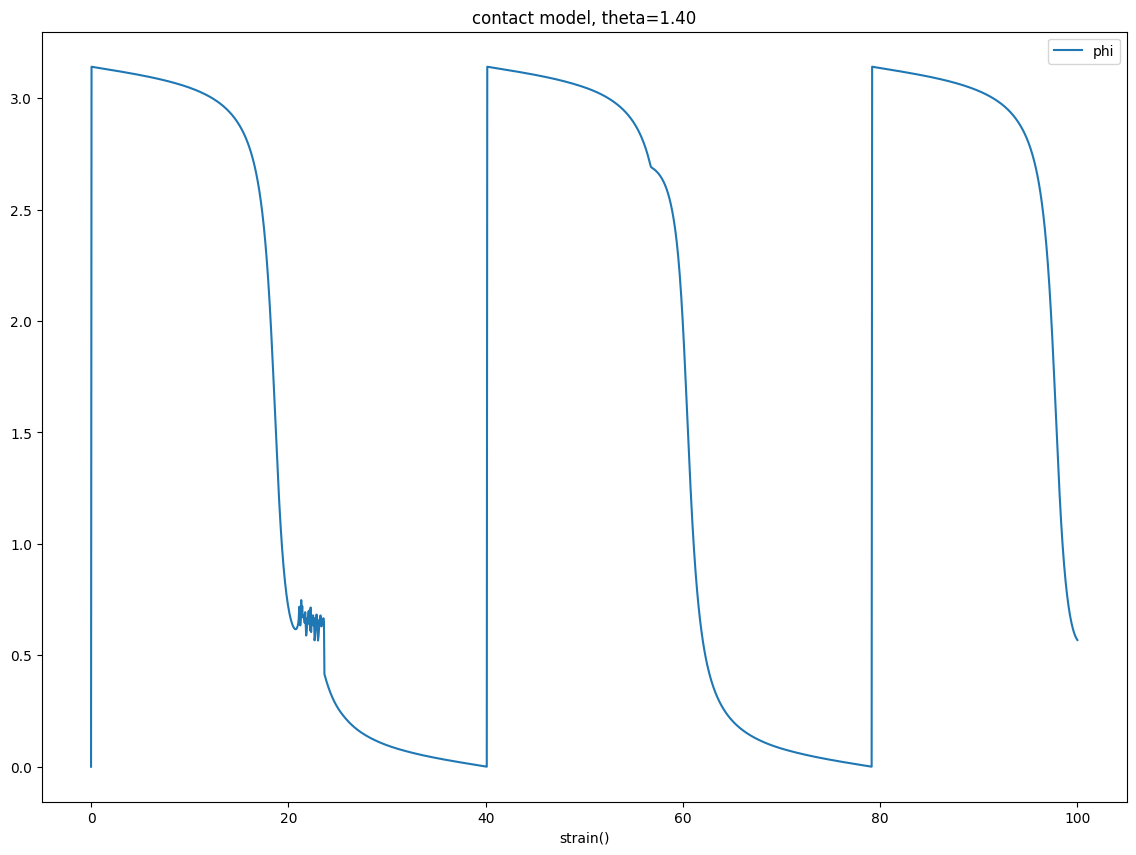

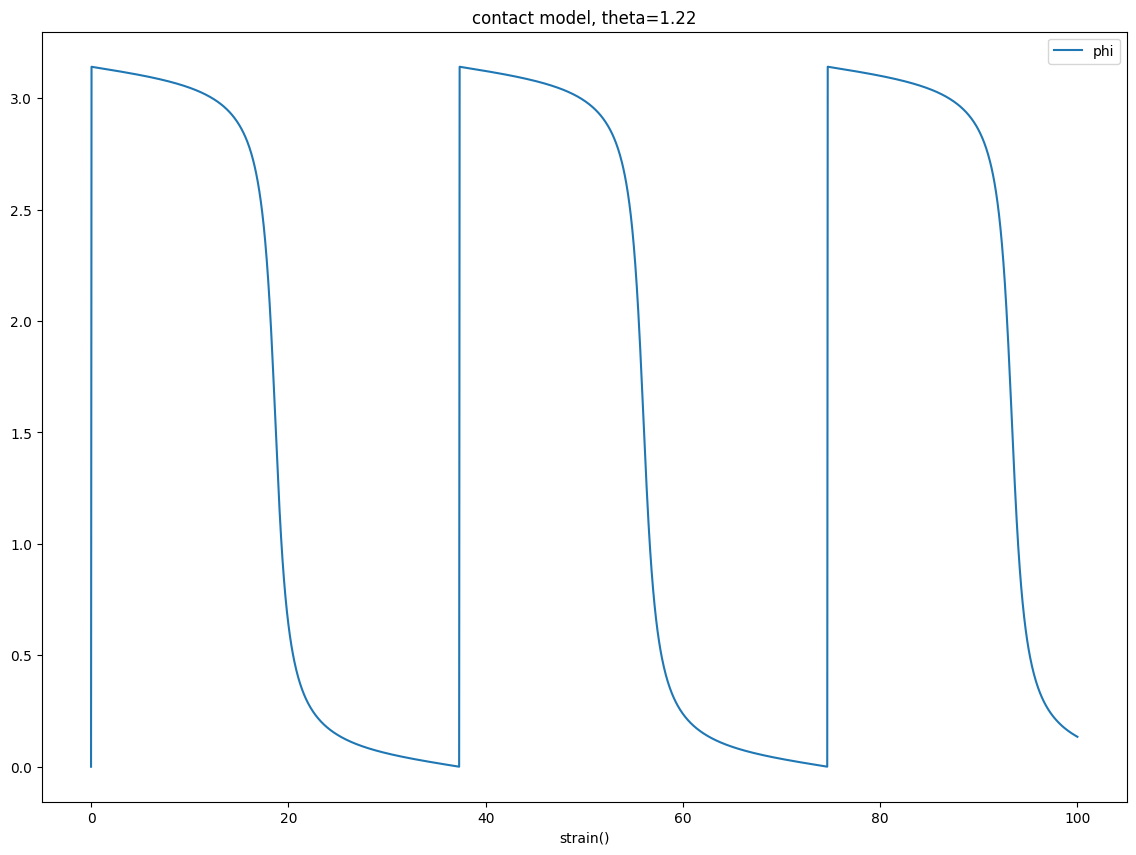

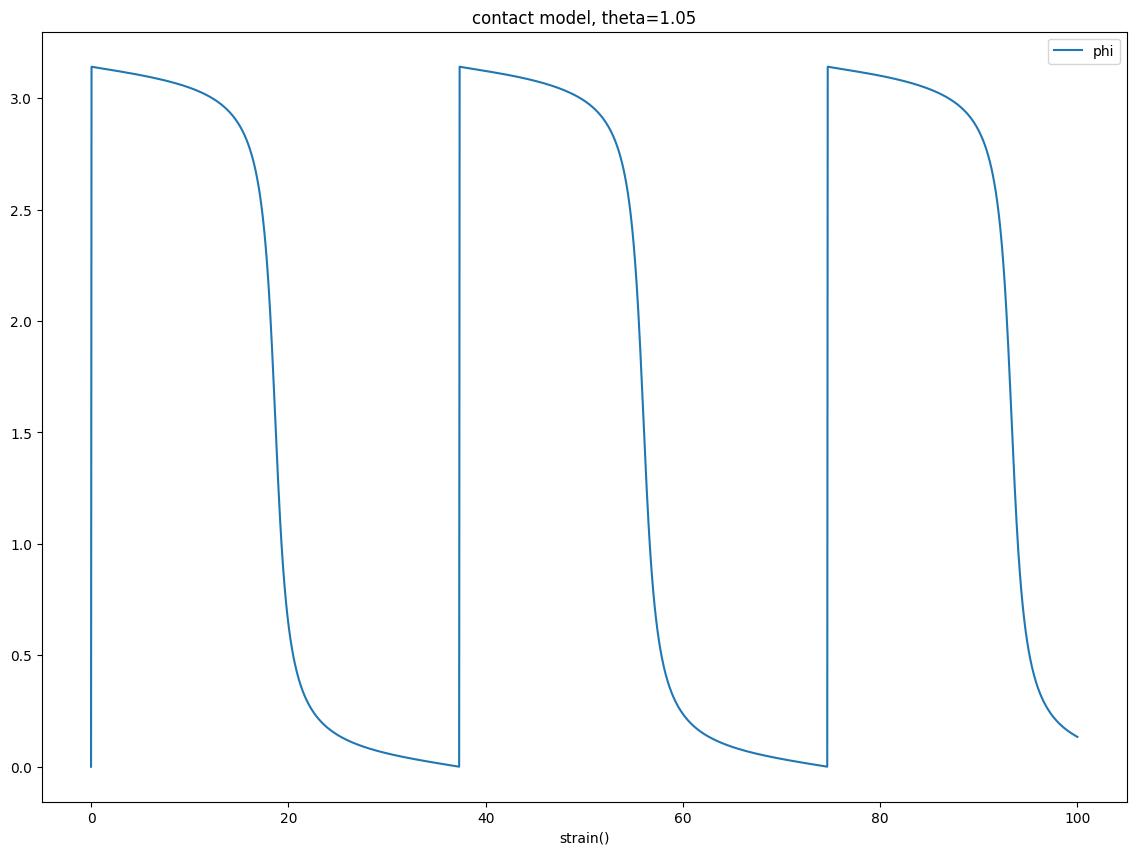

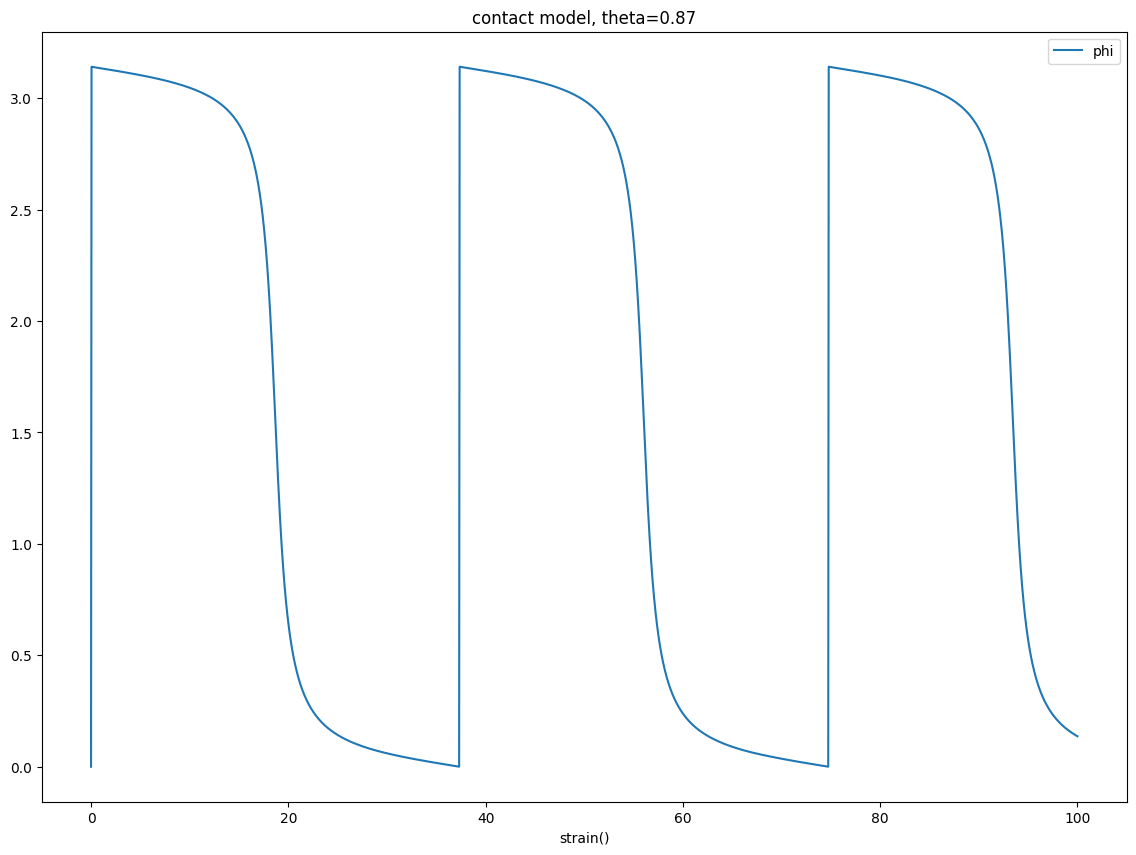

In [7]:
phi=0/180*np.pi
df=pd.DataFrame()
for theta in np.array([90, 80, 70, 60, 50])/180*np.pi:

    p0=np.array([np.sin(theta)*np.cos(phi),np.sin(theta)*np.sin(phi),np.cos(theta)])
    y_L_ratio=0.2
    rho=11.8
    #time span
    t_span=(0,1000)
    t_eval=np.linspace(0,100,num=2000)
    #solve function
    fun=partial(contact_model,rho=rho,y_L_ratio=y_L_ratio)
    res=integrate.solve_ivp(fun,t_span,p0,method='RK45',t_eval=t_eval)
    #plot
    res_df=pd.DataFrame(res.y.T,index=res.t,columns=['x','y','z'])
    res_df.loc[:,'phi']=np.arctan(res_df.y/res_df.x)
    res_df[res_df.phi<0]+=np.pi
    res_df.index.name=r'strain()' 
    df.loc[:,np.round(theta*180/np.pi)]=res_df.loc[:,'phi']
    
    res_df.plot(y='phi',title='contact model, theta={:.2f}'.format(theta),figsize=(14,10))